<a href="https://colab.research.google.com/github/Artemiy2708/-Market-Stability-Simulator/blob/main/LSE_CourseWork_Unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score as r2, roc_auc_score, confusion_matrix
from sklearn.metrics import mean_squared_error as mse
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
# import catboost as cb
#dataset https://www.kaggle.com/code/yasserh/online-customer-segmentation-clustering-approach

# Loading Data

In [ ]:
df = pd.read_excel('Online Retail.xlsx')

In [ ]:
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df['CustomerID'].nunique()

4372

In [ ]:
df['Grand Total'] = df['UnitPrice']*df['Quantity']

In [ ]:
df_grand = pd.DataFrame(df.groupby('CustomerID')['Grand Total'].sum())
df_grand = df_grand.reset_index()
df_grand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CustomerID   4372 non-null   float64
 1   Grand Total  4372 non-null   float64
dtypes: float64(2)
memory usage: 68.4 KB


In [ ]:
df_grand.head(5)

,CustomerID,Grand Total
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [ ]:
df_fr = pd.DataFrame(df.groupby('CustomerID')['InvoiceDate'].nunique())
df_fr = df_fr.rename(columns = {'InvoiceDate': 'Frequency'})
df_fr = df_fr.reset_index()
df_fr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4372 non-null   float64
 1   Frequency   4372 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 68.4 KB


In [ ]:
df_fr.head(5)

,CustomerID,Frequency
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [ ]:
df_segmented = pd.merge(df_grand, df_fr)
df_segmented['Avg Purchase'] = df_segmented['Grand Total']/df_segmented['Frequency']
df_segmented.head(5)

,CustomerID,Grand Total,Frequency,Avg Purchase
0,12346.0,0.00,2,0.000000
1,12347.0,4310.00,7,615.714286
2,12348.0,1797.24,4,449.310000
3,12349.0,1757.55,1,1757.550000
4,12350.0,334.40,1,334.400000


# EDA

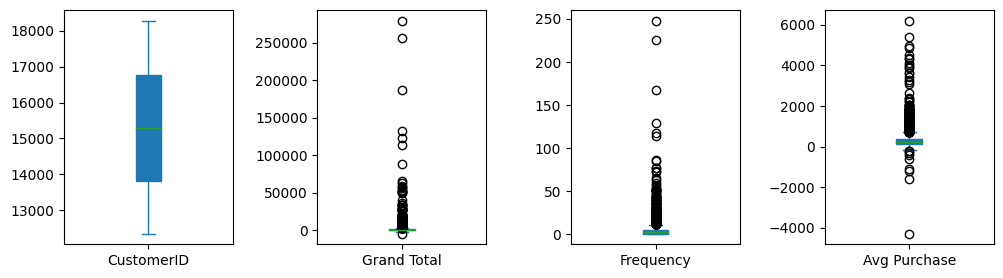

In [ ]:
df_segmented.plot(subplots=True, layout=(4,4), kind='box', figsize=(12,14), patch_artist=True)
plt.subplots_adjust(wspace=0.5);

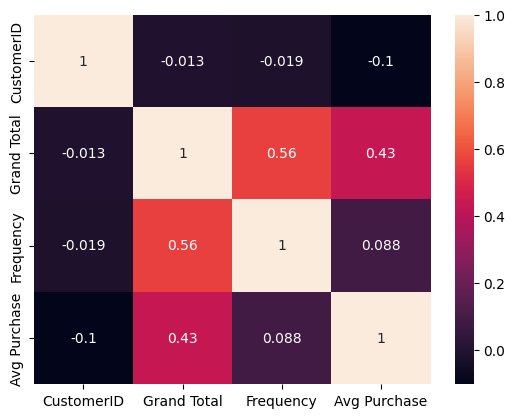

In [ ]:
sns.heatmap(df_segmented.corr(), annot=True)
plt.show()

# Clustering

In [ ]:
!pip3 install pycaret

In [ ]:
# !pip install pandas==1.3.0

Let's have a seperate function that will calculate our metrics and use PCA to reduce our data to 2 dimensions for visualization purposes.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
df_seg1=df_segmented.drop('CustomerID',axis=1)
pca = PCA(2)
df_pca = pca.fit_transform(df_seg1)

def scores(y, labels):
    sil= silhouette_score(y, labels)
    return {'silhouette': sil}

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=38, n_init="auto").fit(df_pca)
label = kmeans.fit_predict(df_pca)
kmeans_score = scores(df_pca, kmeans.labels_)
print(kmeans_score)

{'silhouette': 0.8696612841477275}


Now let's visualize what we have obtained

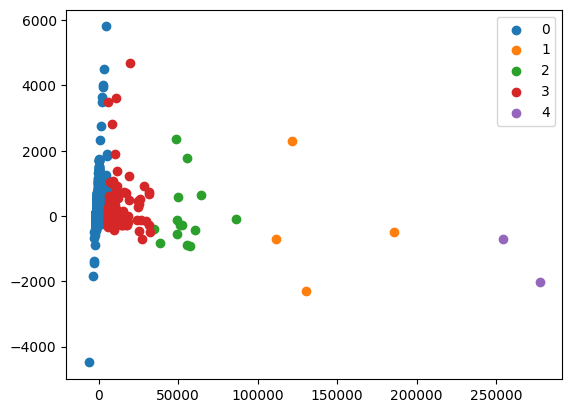

In [ ]:
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(df_pca[label == i , 0] , df_pca[label == i , 1] , label = i)
plt.legend()
plt.show()

# Trying DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(210).fit(df_pca)
label = dbscan.fit_predict(df_pca)
dbscan_score = scores(df_pca, dbscan.labels_)
print(dbscan_score)

{'silhouette': 0.3908288503342424}


In [ ]:
n_clusters_ = len(set(label)) - (1 if -1 in label else 0)
print(n_clusters_)

5


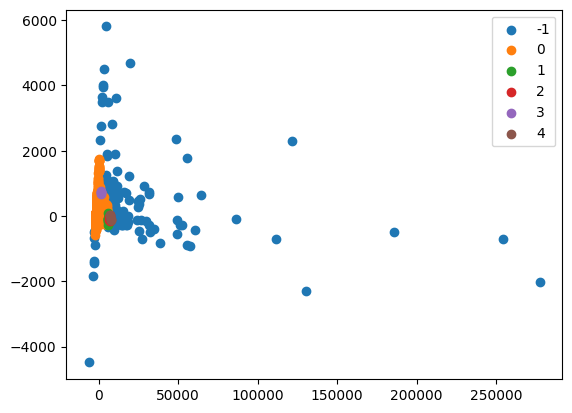

In [ ]:
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(df_pca[label == i , 0] , df_pca[label == i , 1] , label = i)
plt.legend()
plt.show()

# Trying GaussianMixture

In [ ]:
!pip install hdbscan

In [ ]:
!pip install -U numpy

In [ ]:
from sklearn.mixture import GaussianMixture
gaussian_model = GaussianMixture(n_components=6).fit(df_pca)
label = gaussian_model.fit_predict(df_pca)

In [ ]:
score = silhouette_score(df_pca, label, metric='euclidean')
print(score)
score2 = calinski_harabasz_score(df_pca, label)
print(score2)

0.18542649992223093
2135.0676347984736


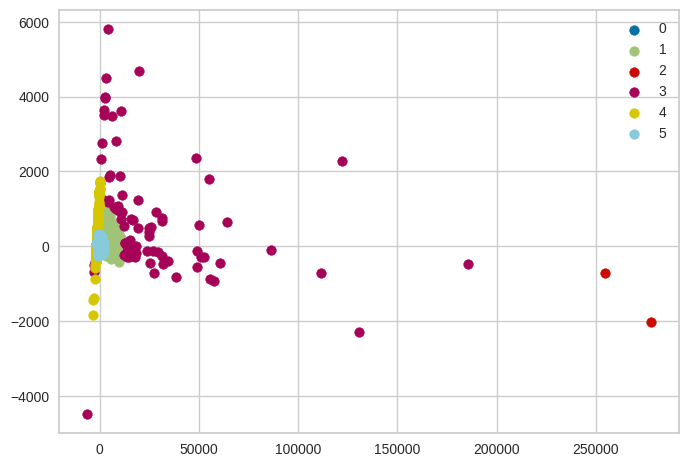

In [ ]:
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(df_pca[label == i , 0] , df_pca[label == i , 1] , label = i)
plt.legend()
plt.show()

# Also try BIRCH

In [ ]:
#Why? - it works great on large datasets
from sklearn.cluster import Birch
birch_model = Birch(threshold=1, n_clusters=5).fit(df_pca)
label = birch_model.fit_predict(df_pca)
birch_score = scores(df_pca, birch_model.labels_)
print(birch_score)

{'silhouette': 0.9154640978772638}


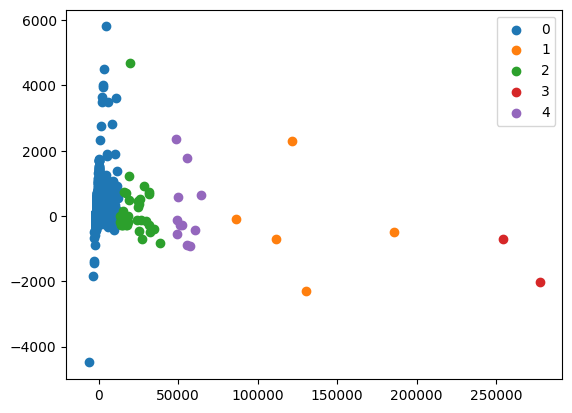

In [ ]:
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(df_pca[label == i , 0] , df_pca[label == i , 1] , label = i)
plt.legend()
plt.show()

# Results and discussion of clusters

In [ ]:
res = pd.DataFrame(data=[list(kmeans_score.values()), list(dbscan_score.values()), list(birch_score.values())], columns=list(birch_score.keys()))
res = res.transpose()
res = res.rename(columns={0:"K-Means", 1:"DBSCAN", 2:"BIRCH"})
res.style.highlight_max(color = 'green', axis = 1)

,K-Means,DBSCAN,BIRCH
silhouette,0.869661,0.390829,0.915464


In [ ]:
cluster0 = df_segmented[label == 0]
cluster1 = df_segmented[label == 1]
cluster2 = df_segmented[label == 2]
cluster3 = df_segmented[label == 3]
cluster4 = df_segmented[label == 4]

clusters = [cluster0,cluster1,cluster2,cluster3,cluster4]

<ipython-input-94-1bf299ea9d0d>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i)
<ipython-input-94-1bf299ea9d0d>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=feature['Grand Total'],kde=True, palette=color)
<ipython-input-94-1bf299ea9d0d>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=feature['Grand Total'],kde=True, palette=color)
<ipython-input-94-1bf299ea9d0d>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i)
<ipython-input-94-1bf299ea9d0d>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=feature['Grand Total'],kde=True, palette=color)
<ipy

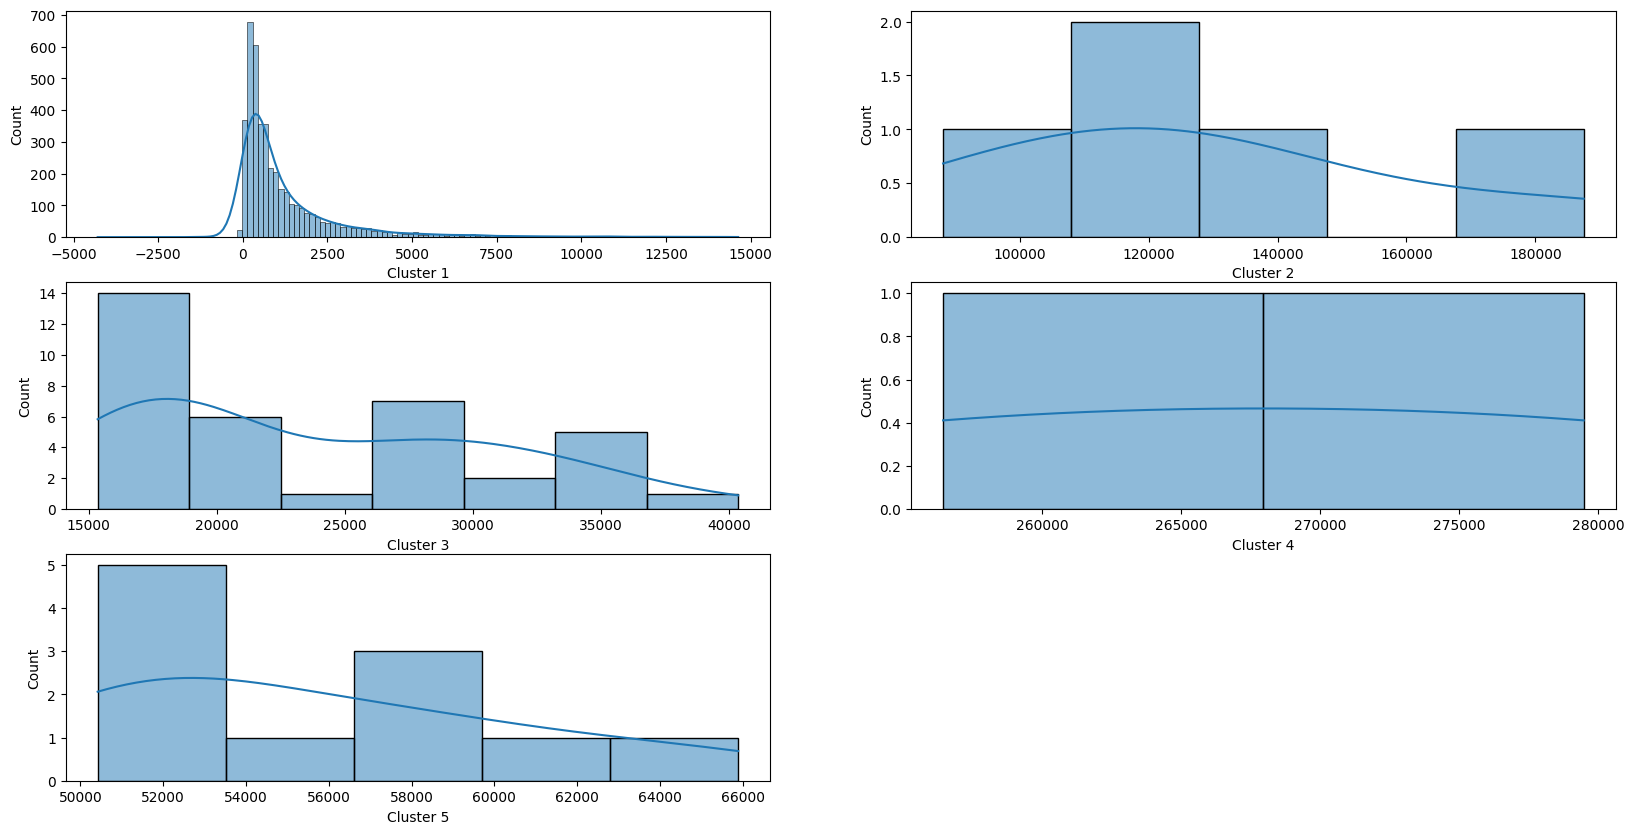

In [ ]:
color = 'summer'
fig, axs = plt.subplots(5, 1, figsize=(20,10))
i = 1
for feature in clusters:
  plt.subplot(3,2,i)
  sns.histplot(data=feature['Grand Total'],kde=True, palette=color)
  plt.xlabel('Cluster '+ str(i))
  i = i+1

<ipython-input-95-368b26635804>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i)
<ipython-input-95-368b26635804>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=feature['Frequency'],kde=True, palette=color)
<ipython-input-95-368b26635804>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=feature['Frequency'],kde=True, palette=color)
<ipython-input-95-368b26635804>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i)
<ipython-input-95-368b26635804>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=feature['Frequency'],kde=True, palette=color)
<ipython-i

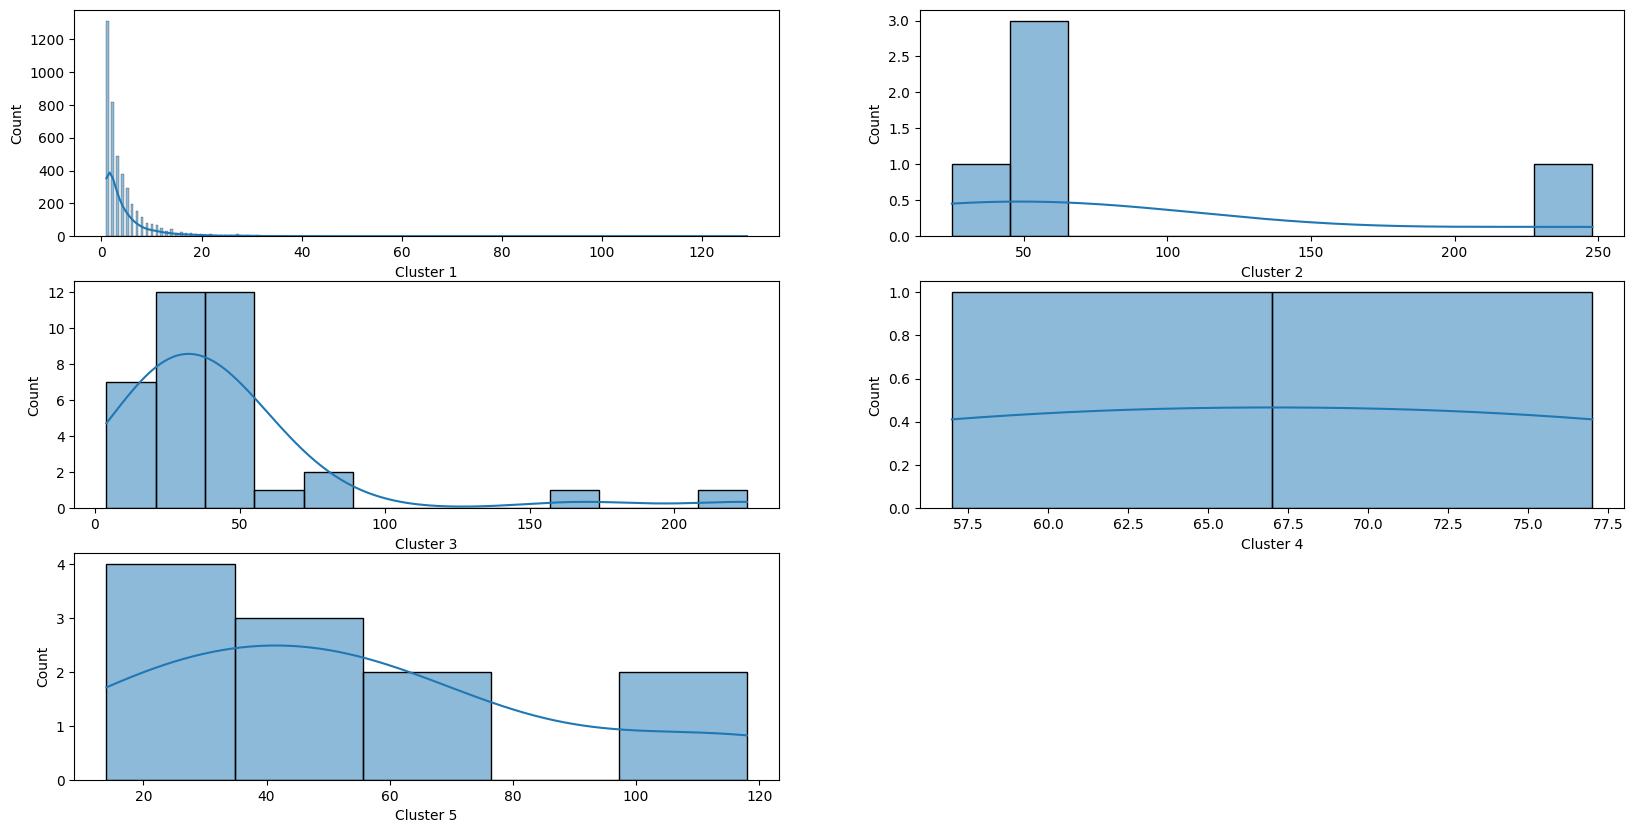

In [ ]:
color = 'summer'
fig, axs = plt.subplots(5, 1, figsize=(20,10))
i = 1
for feature in clusters:
  plt.subplot(3,2,i)
  sns.histplot(data=feature['Frequency'],kde=True, palette=color)
  plt.xlabel('Cluster '+ str(i))
  i = i+1

<ipython-input-96-7a5047b083f1>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i)
<ipython-input-96-7a5047b083f1>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=feature['Avg Purchase'],kde=True, palette=color)
<ipython-input-96-7a5047b083f1>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=feature['Avg Purchase'],kde=True, palette=color)
<ipython-input-96-7a5047b083f1>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i)
<ipython-input-96-7a5047b083f1>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=feature['Avg Purchase'],kde=True, palette=color)
<

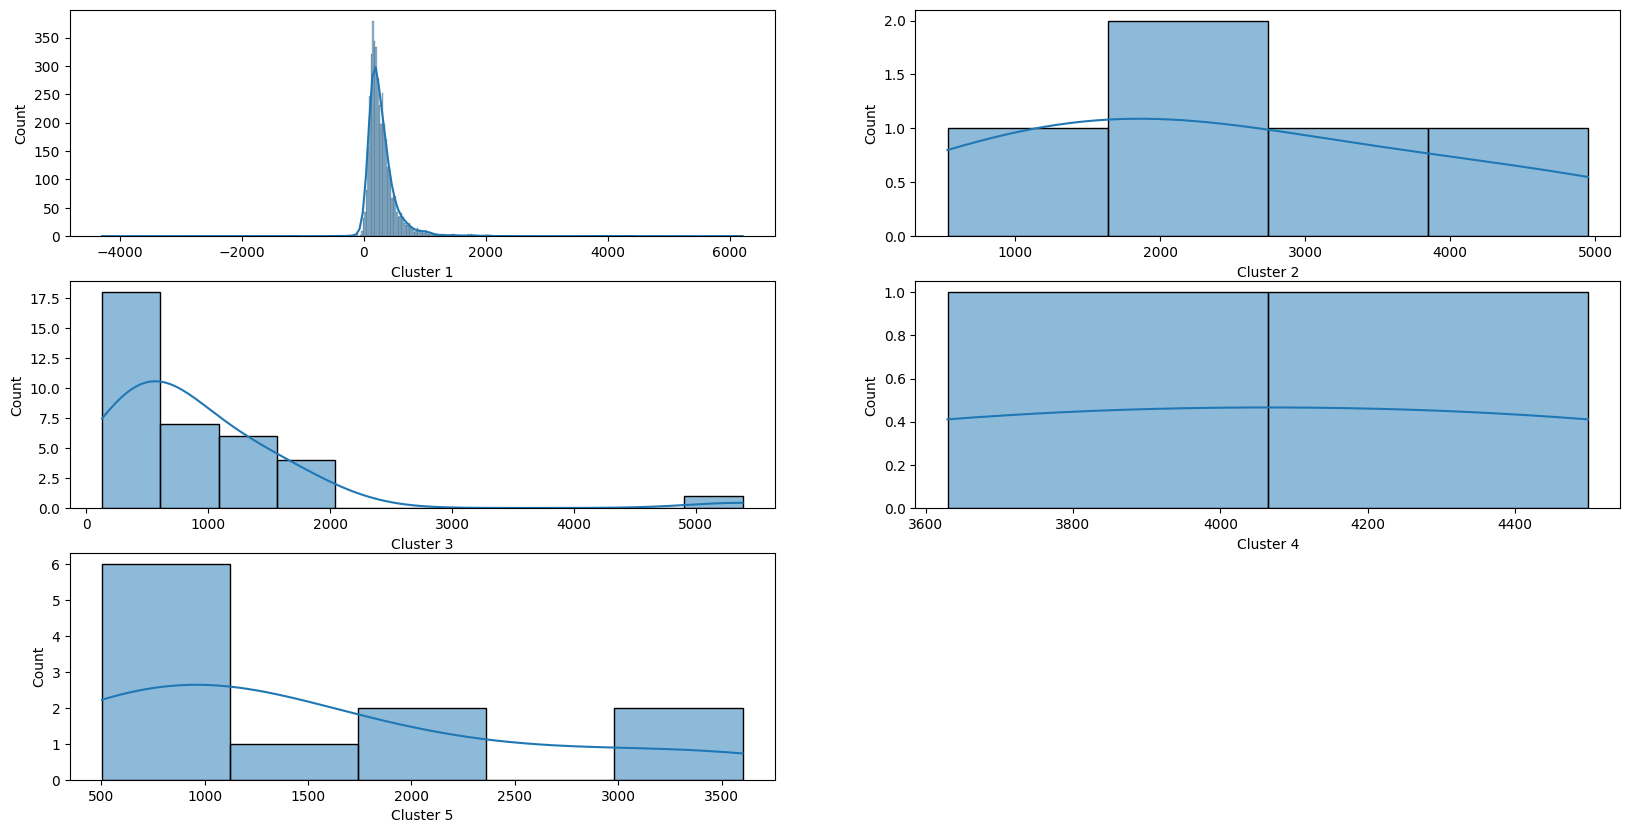

In [ ]:
color = 'summer'
fig, axs = plt.subplots(5, 1, figsize=(20,10))
i = 1
for feature in clusters:
  plt.subplot(3,2,i)
  sns.histplot(data=feature['Avg Purchase'],kde=True, palette=color)
  plt.xlabel('Cluster '+ str(i))
  i = i+1

In [ ]:
cluster0.describe()

,CustomerID,Grand Total,Frequency,Avg Purchase
count,5.00000,5.000000,5.00000,5.000000
mean,15288.60000,129057.952000,88.00000,2502.346243
std,2196.22706,36658.292209,90.64767,1706.460878
min,12415.00000,88125.380000,25.00000,534.567016
25%,14156.00000,113384.140000,47.00000,1744.371385
50%,14911.00000,123725.450000,55.00000,1875.008085
75%,17450.00000,132572.620000,65.00000,3408.766727
max,17511.00000,187482.170000,248.00000,4949.018000


In [ ]:
cluster1.describe()

,CustomerID,Grand Total,Frequency,Avg Purchase
count,283.000000,283.000000,283.000000,283.000000
mean,14951.975265,7875.847420,18.565371,685.773909
std,1827.535119,3755.789787,13.748957,823.470137
min,12347.000000,3861.000000,1.000000,90.722118
25%,13158.500000,5155.120000,10.000000,316.335913
50%,14936.000000,6612.180000,16.000000,439.033125
75%,16654.000000,9262.650000,24.000000,699.371429
max,18251.000000,21535.900000,129.000000,6207.670000


In [ ]:
cluster2.describe()

,CustomerID,Grand Total,Frequency,Avg Purchase
count,27.000000,27.000000,27.000000,27.000000
mean,15136.518519,40928.794815,56.814815,1152.917496
std,1706.961929,13322.664031,49.401057,829.264148
min,12748.000000,25748.350000,14.000000,129.209333
25%,13735.500000,28865.490000,22.000000,610.357708
50%,15061.000000,33805.690000,43.000000,1042.860385
75%,16377.500000,52287.280000,68.000000,1459.886667
max,17949.000000,65892.080000,225.000000,3601.106429


In [ ]:
cluster3.describe()

,CustomerID,Grand Total,Frequency,Avg Purchase
count,2.000000,2.000000,2.000000,2.000000
mean,16374.000000,267963.755000,67.000000,4064.324205
std,2443.761036,16299.186073,14.142136,614.612508
min,14646.000000,256438.490000,57.000000,3629.727532
25%,15510.000000,262201.122500,62.000000,3847.025869
50%,16374.000000,267963.755000,67.000000,4064.324205
75%,17238.000000,273726.387500,72.000000,4281.622541
max,18102.000000,279489.020000,77.000000,4498.920877


In [ ]:
cluster4.describe()

,CustomerID,Grand Total,Frequency,Avg Purchase
count,4055.000000,4055.000000,4055.000000,4055.000000
mean,15324.514180,933.392420,3.618249,281.480362
std,1712.178579,943.998632,3.498504,247.978763
min,12346.000000,-4287.630000,1.000000,-4287.630000
25%,13847.000000,270.975000,1.000000,147.175000
50%,15342.000000,590.340000,2.000000,225.918333
75%,16794.500000,1295.345000,5.000000,349.163333
max,18287.000000,4455.730000,39.000000,3096.000000
